## CV Challenge: Task 2
Welcome to the first notebook of the CV Challenge project, where we aim to solve the problem of object detection and classification. This notebook specifically focuses on preparing the data into the TFRecordDataset format, which is a highly efficient and scalable way to handle large datasets in TensorFlow.

This notebook is part of a two-part series:

- Task1_cv_challenge_forstehaeusler.ipynb:

- **Task2_cv_challenge_forstehaeusler.ipynb:** 





## Task 1 - Classification

Before diving into training, it's crucial to ensure that you've run `Task 1`, where we prepared the data in the TFRecordDataset format. This ensures that our dataset is properly formatted and ready for training.

To begin exploring this notebook, we first need to specify the **directory where the TFRecordDatasets for training and testing** are stored. The dimensions `image_height`, `image_width` and `n_color_channels` correspond to the shape dimensions of the image data in our prepared dataset as well as the number of surcface defects `out_classes` from Task 1. These parameters are essential for configuring our image classification model.

Let's proceed by setting up the directory paths and configuring our model for training

In [1]:
#Define image Dimensions for the base_model corresponding to the preprocessed Dataset from Task1
image_height = 200
image_width = 200
n_color_channels = 3

out_classes = 6

# Specify the directory path from where the TFRecordDataset will be read
save_tfRecord_folder = "TFRecordDataset"            

The code in this section prepares `training`, `validation`, and `testing datasets` from TFRecord files stored in specific subfolders. It extracts **images** and **labels**, converts labels to **one-hot encoded** format, and creates datasets accordingly.


In [2]:
from src.utils_task2 import extract_label_and_img, transform_label_to_OneHotEncoded, create_train_and_validation_dataset, create_test_dataset, transform_label_to_SparseCategorical
import os

save_tfRecord_sub_folder = [os.path.join(save_tfRecord_folder, "train"), os.path.join(save_tfRecord_folder, "test")]

#creat all three datasets (train, validation and test) from TFRecord Folder created in Task1
for sub_folder in save_tfRecord_sub_folder:
    images, labels = extract_label_and_img(sub_folder)
    #one_hot_labels = transform_label_to_OneHotEncoded(labels, out_classes)
    sparse_encoded = transform_label_to_SparseCategorical(labels)
    if sub_folder == os.path.join(save_tfRecord_folder, "train"):
        train_dataset, val_dataset = create_train_and_validation_dataset(images, sparse_encoded, val_size=0.2, batch_size=32)
        print(f"Info:\t\tTraining and Valadiation Datasets are created!")
    elif sub_folder == os.path.join(save_tfRecord_folder, "test"):
        test_dataset = create_test_dataset(images, sparse_encoded, batch_size=32)
        print(f"Info:\t\tTesting Datasets is created!")  

Info:		Convertion to Sparse-Encoding was succsesfull
Info:		Training and Valadiation Datasets are created!
Info:		Convertion to Sparse-Encoding was succsesfull
Info:		Testing Datasets is created!


## Setting up Transfer Learning Model for Image Classification

This code snippet sets up a transfer learning model for image classification using the Xception architecture, leveraging pre-trained weights from the ImageNet dataset and implementing custom classification layers for fine-tuning.

1. Base Model Loading: Xception, a pre-trained model on ImageNet, is loaded as the base model. We exclude the top classification layers.

2. Freezing Base Model: We freeze the base model's layers to retain the pre-trained weights, preventing them from being updated during training.

3. Adding Custom Layers: Additional layers are added on top of the base model for classification, including pooling, dense, and dropout layers.

4. Callbacks Definition: Two callbacks are defined:
    - EarlyStopping: Stops training if the validation loss doesn't improve after a certain number of epochs.
    - ReduceLROnPlateau: Reduces the learning rate if the validation loss stops improving.

This setup helps adapt the pre-trained Xception model for our specific classification task while providing mechanisms to prevent overfitting and adjust the learning rate during training.



In [3]:
import tensorflow as tf

#load Xception as base model with weigths pretrained as "imagmet"
base_model = tf.keras.applications.Xception(input_shape=(image_height, image_width, n_color_channels),
                                            include_top=False,
                                            weights="imagenet")


# Freeze the base model layers
base_model.trainable = False

# Adding layers on top of the base_model as defined in TASK2 
extented_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),            
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(out_classes, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))   # Activation could also be 'softmax' for classification
])

early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=6,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=False,
        start_from_epoch=10
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=1e-10, 
        patience=0,  
        min_delta=0.0001, 
        cooldown=0,
        verbose=1,
        mode='auto',
        min_lr=1e-17
)


This code section imports necessary functions and classes for visualization from a custom module called train_visulation. It defines a project name, to name the training, and creates a specific directory to store logs. These logs contain crucial information such as training and validation loss, as well as accuracy. Additionally, it sets up a path to save model checkpoints to ensure the best training state is preserved. Furthermore, it initializes a custom callback class named CustomCallbacks, likely used for creating customized logs and additional functionalities beyond standard Keras callbacks. These logs may include visualizations of training and validation loss and accuracy to better understand and monitor the training progress.

In [4]:
from src.train_visulation import create_run_directory, initialize_logging, CustomCallbacks

# Define log directory and path
project_name = "relu_batch_size_32"
run_dir = create_run_directory(project_name)
log_path = initialize_logging(run_dir)

ckpt_dir = os.path.join(run_dir, "model.h5")
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_dir,
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None
)

custom_callbacks = CustomCallbacks(log_path, run_dir)

## Configurate Model Training
This section configures the extended model for training, specifying optimizer, loss function, and metrics. Then, it initiates training using the prepared `training` and `validation datasets`. Finally, it prints messages for the start and end of training, along with the number of batches used for training and validation.

In [5]:
extented_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.99, weight_decay=0),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

print(f"########## Start Training ##############\n")

print(f"{len(list(train_dataset))} batches used for training")
print(f"{len(list(val_dataset))} batches used for validation\n\n")

# Train the model
history = extented_model.fit(
    train_dataset,
    epochs=100,
    callbacks=[custom_callbacks, early_stop, lr_scheduler, model_ckpt],
    validation_data=val_dataset,
)
print(f"\n\n######### Finished Training ############")


########## Start Training ##############
36 batches used for training
9 batches used for validation
Epoch 1/100
36/36 [==============================] - 72s 2s/step - loss: 1.6154 - accuracy: 0.2980 - val_loss: 1.3350 - val_accuracy: 0.5729 - lr: 0.0010


c:\Users\chris\anaconda3\envs\cv_challenge\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
36/36 [==============================] - 93s 3s/step - loss: 1.3285 - accuracy: 0.4257 - val_loss: 1.0629 - val_accuracy: 0.6979 - lr: 0.0010
Epoch 3/100
36/36 [==============================] - 96s 3s/step - loss: 1.1548 - accuracy: 0.5274 - val_loss: 0.8787 - val_accuracy: 0.8264 - lr: 0.0010
Epoch 4/100
36/36 [==============================] - 82s 2s/step - loss: 1.0662 - accuracy: 0.5743 - val_loss: 0.7314 - val_accuracy: 0.9028 - lr: 0.0010
Epoch 5/100
36/36 [==============================] - 81s 2s/step - loss: 0.9767 - accuracy: 0.6073 - val_loss: 0.6226 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/100
36/36 [==============================] - 81s 2s/step - loss: 0.9143 - accuracy: 0.6212 - val_loss: 0.5374 - val_accuracy: 0.9479 - lr: 0.0010
Epoch 7/100
36/36 [==============================] - 99s 3s/step - loss: 0.8552 - accuracy: 0.6455 - val_loss: 0.4501 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 8/100
36/36 [==============================] - 88s 2s/step - loss: 0.8

## Evaluate Model Training


The Evaluation of the pre-trained neural network model is performed on the test dataset and visualizes its performance using a confusion matrix. It loads the model, computes the test metrics, extracts labels and predictions from the test dataset, computes the confusion matrix, and visualizes it using Matplotlib. Finally, the plotted confusion matrix is saved as an image file for further analysis.

12/12 [==============================] - 24s 2s/step - loss: 0.3320 - accuracy: 0.9306
Test Loss: 0.3319953382015228
Test Accuracy: 0.9305555820465088
1/1 [==============================] - 2s 2s/step
Confusion matrix, without normalization


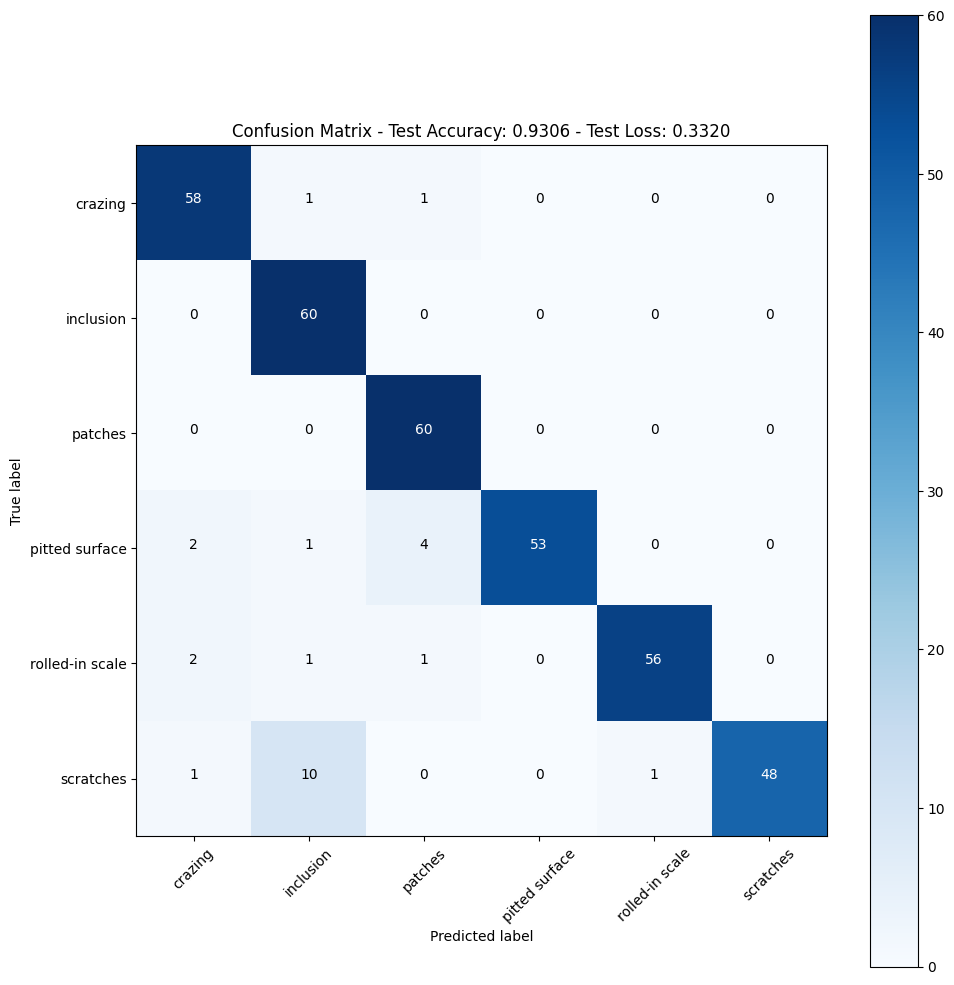

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

classes = ['crazing', 'inclusion', 'patches', 'pitted surface', 'rolled-in scale', 'scratches']

test_loss, test_accuracy = extented_model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

def extract_labels_and_predictions(dataset):
    labels = []
    predictions = []
    for image, label in dataset:
        labels.append(label.numpy())
        predictions.append(np.argmax(extented_model.predict(image), axis=1))
    return np.concatenate(labels), np.concatenate(predictions)

test_labels, test_predictions = extract_labels_and_predictions(test_dataset)
conf_matrix = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - Test Accuracy: {test_accuracy:.4f} - Test Loss: {test_loss:.4f}')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

normalize = False

if normalize:
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
else:
    print('Confusion matrix, without normalization')

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig(os.path.join(run_dir, f'Confusion Matrix__Test Accuracy-{test_accuracy:.4f}__Test Loss-{test_loss:.4f}.png'))